# Machine Learning
Ingest the data we have gathered into a neural network. 

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('D:\\malware\\output.csv')

df['size_dif'] = df['size_of_image'] - df['file_size']
df['stack_dif'] = df['size_of_stack_reserve'] - df['size_of_stack_commit']
df['heap_dif'] = df['size_of_heap_reserve'] - df['size_of_heap_commit']

df['imports'] = df['imports'].apply(lambda i: ' '.join(i.strip('[]').replace("'", "").replace(" ", "").split(',')))

normalize_candidates = [
    'file_size', 'size_of_image', 'size_of_code', 'size_of_stack_reserve',
    'size_of_stack_commit', 'size_of_heap_reserve', 'size_of_heap_commit',
    'size_dif', 'stack_dif', 'heap_dif', 'file_entropy', 'number_of_sections' 
]

df[normalize_candidates].describe()

,file_size,size_of_image,size_of_code,size_of_stack_reserve,size_of_stack_commit,size_of_heap_reserve,size_of_heap_commit,size_dif,stack_dif,heap_dif,file_entropy,number_of_sections
count,9.289800e+04,9.289800e+04,9.289800e+04,9.289800e+04,9.289800e+04,9.289800e+04,9.289800e+04,9.289800e+04,9.289800e+04,9.289800e+04,92898.000000,92898.000000
mean,6.252095e+05,8.138984e+05,1.581340e+06,1.011728e+06,1.762707e+04,1.064151e+06,1.933732e+04,1.886889e+05,9.941011e+05,1.044814e+06,6.396096,4.720457
std,1.740078e+06,5.962810e+06,4.839191e+07,3.152560e+06,3.145334e+06,6.397040e+06,3.969503e+06,5.790411e+06,9.616575e+05,2.452672e+06,1.121927,2.049490
min,5.120000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.886902e+08,-4.123059e+07,-1.579827e+07,0.036711,0.000000
25%,7.396050e+04,8.192000e+04,2.304000e+04,1.048576e+06,4.096000e+03,1.048576e+06,4.096000e+03,4.410000e+03,1.032192e+06,1.044480e+06,5.917650,3.000000
50%,2.466315e+05,2.293760e+05,7.782400e+04,1.048576e+06,4.096000e+03,1.048576e+06,4.096000e+03,1.484800e+04,1.044480e+06,1.044480e+06,6.453194,5.000000
75%,6.374400e+05,6.389760e+05,2.621440e+05,1.048576e+06,4.096000e+03,1.048576e+06,4.096000e+03,2.573400e+04,1.044480e+06,1.044480e+06,7.216248,6.000000
max,2.013673e+08,1.108480e+09,4.294967e+09,9.171352e+08,9.583658e+08,1.948318e+09,1.208490e+09,1.107230e+09,3.355034e+07,7.398284e+08,7.999939,72.000000


In [2]:
# Split the data into training, validation and testing. 
train, test = train_test_split(df, test_size=0.2)
train, valid = train_test_split(train, test_size=0.2)

#imp_ds = tf.data.Dataset.from_tensor_slices(df['imports'])
#type_ds = tf.data.Dataset.from_tensor_slices(df['file_type'])

def Normalize(df):
    return (df-df.min())/(df.max()-df.min())

for cand in normalize_candidates:
    df[cand] = Normalize(df[cand])


In [68]:
def Build_Model(learning_rate, feature_layer, metrics):
    model = tf.keras.Sequential()
    model.add(feature_layer)
    model.add(layers.Dense(
        64,
        activation='relu',
        kernel_regularizer='l2',
        name='Hidden_1'
    ))
    model.add(layers.Dense(
        32,
        activation='relu',
        kernel_regularizer='l2',
        name='Hidden_2'
    ))
    model.add(layers.Dropout(0.1, name='Dropout'))

    
    model.add(layers.Dense(
        1,
        activation='sigmoid',
        name='Sigmoid'
    ))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=metrics
    )

    return model


In [69]:
def Train_Model(
    model, dataset, epochs,
    label_name, valid,
    batch_size=None, 
    shuffle=True
):
    '''Feed dataset and label, then train model. '''

    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    
    validation_set = {name:np.array(value) for name, value in valid.items()}
    validation_label = np.array(validation_set.pop(label_name))

    history = model.fit(
        x=features, 
        y=label, 
        batch_size=batch_size,
        epochs=epochs,
        shuffle=shuffle,
        validation_data=(validation_set, validation_label)
    )

    epochs = history.epoch

    hist = pd.DataFrame(history.history)

    return epochs, hist 

In [5]:
def Plot_Curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


# Main Model

In [6]:
feature_columns = []

for i in normalize_candidates:
    feature_columns.append(
        feature_column.numeric_column(i)
    )

feature_layer = layers.DenseFeatures(feature_columns)

In [7]:
# parameters
learning_rate = 0.003
epochs = 5
batch_size=32
classification_threshold = 0.55
label_name = 'label'

metrics = [
    tf.keras.metrics.BinaryAccuracy(
        name='accuracy', 
        threshold=classification_threshold
    ),
    tf.keras.metrics.Precision(
        name='precision',
        thresholds=classification_threshold
    ),
    tf.keras.metrics.Recall(
        name="recall",
        thresholds=classification_threshold
    ),
]

# Rename the column name to match the expect input.
normalize_candidates.append('label') 

model = Build_Model(learning_rate, feature_layer, metrics)

epochs, hist = Train_Model(model, train[normalize_candidates], epochs, label_name, valid[normalize_candidates], batch_size)

metrics_to_plot = ['accuracy']#, 'precision', 'recall']

Plot_Curve(epochs, hist, metrics_to_plot)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "C:\Program Files\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Program Files\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Program Files\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\blake\AppData\Local\Temp/ipykernel_21168/3283290214.py", line 28, in <module>
      epochs, hist = Train_Model(model, train[normalize_candidates], epochs, label_name, valid[normalize_candidates], batch_size)
    File "C:\Users\blake\AppData\Local\Temp/ipykernel_21168/2493786077.py", line 15, in Train_Model
      history = model.fit(
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "C:\Program Files\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Program Files\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Program Files\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\blake\AppData\Local\Temp/ipykernel_21168/3283290214.py", line 28, in <module>
      epochs, hist = Train_Model(model, train[normalize_candidates], epochs, label_name, valid[normalize_candidates], batch_size)
    File "C:\Users\blake\AppData\Local\Temp/ipykernel_21168/2493786077.py", line 15, in Train_Model
      history = model.fit(
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential/Output/BiasAdd:0) = ] [[0][0][0]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_1/Assert/AssertGuard/pivot_f/_23/_87]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential/Output/BiasAdd:0) = ] [[0][0][0]...] [y (Cast_8/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1730]

In [ ]:
features = {name:np.array(value) for name, value in train[normalize_candidates].items()}
label = np.array(features.pop(label_name))
main_pred = model.predict(features)

# File Types

In [8]:
layer_name = 'file_type'
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(
    embedding, 
    input_shape=[],
    dtype=tf.string,
    trainable=True,
    name=layer_name
)
hub_layer(train['file_type'][:1])

#vectorize_layer_type = layers.TextVectorization(
#    output_mode='int',
#    output_sequence_length=8
#)
#vectorize_layer_type.adapt(train['file_type'])
#vectorize_layer_type(df['file_type'])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.3059429 ,  0.04854507, -0.10244771,  0.00235147,  0.01862714,
         0.02173721, -0.00593309,  0.02614102,  0.01498474, -0.1277027 ,
        -0.03943286,  0.32368445, -0.04943154, -0.14988844,  0.15822528,
         0.43203717,  0.12320857, -0.0158817 ,  0.36795557,  0.28294122,
         0.06565747, -0.00249822,  0.34604615, -0.10406474, -0.06754161,
        -0.27265453, -0.05341744,  0.30954793, -0.08949388,  0.00560029,
        -0.19600613, -0.04928539, -0.35421884,  0.0037315 ,  0.1883006 ,
        -0.2942362 ,  0.29516977,  0.14750236, -0.17053317,  0.23857348,
        -0.00611515, -0.14055108,  0.0138289 ,  0.0108629 , -0.45722714,
        -0.02904043,  0.2584269 ,  0.02794387, -0.2345884 ,  0.23760574]],
      dtype=float32)>

Epoch 1/5


C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1858/1858 [==============================] - 51s 27ms/step - loss: 0.3652 - accuracy: 0.8391 - precision: 0.9018 - recall: 0.8045 - val_loss: 0.3279 - val_accuracy: 0.8674 - val_precision: 0.9014 - val_recall: 0.8602
Epoch 2/5
1858/1858 [==============================] - 51s 27ms/step - loss: 0.3297 - accuracy: 0.8583 - precision: 0.9021 - recall: 0.8421 - val_loss: 0.3221 - val_accuracy: 0.8668 - val_precision: 0.9027 - val_recall: 0.8575
Epoch 3/5
1858/1858 [==============================] - 52s 28ms/step - loss: 0.3263 - accuracy: 0.8603 - precision: 0.9019 - recall: 0.8462 - val_loss: 0.3196 - val_accuracy: 0.8677 - val_precision: 0.9018 - val_recall: 0.8602
Epoch 4/5
1858/1858 [==============================] - 51s 27ms/step - loss: 0.3256 - accuracy: 0.8609 - precision: 0.9017 - recall: 0.8476 - val_loss: 0.3201 - val_accuracy: 0.8677 - val_precision: 0.9018 - val_recall: 0.8602
Epoch 5/5
1858/1858 [==============================] - 51s 27ms/step - loss: 0.3242 - accuracy: 0.8616

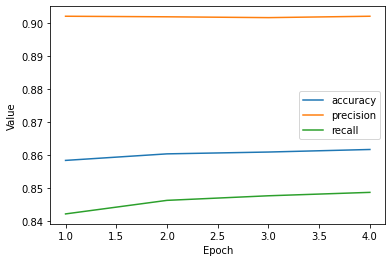

In [11]:
# parameters
learning_rate = 0.003
epochs = 5
batch_size=32
classification_threshold = 0.8
label_name = 'label'

metrics = [
    tf.keras.metrics.BinaryAccuracy(
        name='accuracy', 
        threshold=classification_threshold
    ),
    tf.keras.metrics.Precision(
        name='precision',
        thresholds=classification_threshold
    ),
    tf.keras.metrics.Recall(
        name="recall",
        thresholds=classification_threshold
    ),
]

# Rename the column name to match the expect input. 
train.rename(columns={"file_type":'file_type_input'}, inplace=True)
valid.rename(columns={"file_type":'file_type_input'}, inplace=True)
test.rename(columns={"file_type":'file_type_input'}, inplace=True)

model = Build_Model(learning_rate, hub_layer, metrics)

epochs, hist = Train_Model(model, train[['file_type_input','label']], epochs, label_name, valid[['file_type_input', 'label']], batch_size)

metrics_to_plot = ['accuracy', 'precision', 'recall']

Plot_Curve(epochs, hist, metrics_to_plot)

In [12]:
features = {name:np.array(value) for name, value in train[['file_type_input','label']].items()}
label = np.array(features.pop(label_name))
type_pred = model.predict(features)

# Imports

In [13]:
layer_name = 'imports'
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(
    embedding, 
    input_shape=[],
    dtype=tf.string,
    trainable=True,
    name=layer_name
)
hub_layer(train['imports'][:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.5452786 , -0.3172977 , -0.07704936,  0.2036959 ,  0.38697574,
        -0.1419868 , -0.13361807,  0.12941073,  0.1000542 , -0.24626689,
        -0.17147727,  0.12623933, -0.16933653,  0.16426836,  0.19530015,
         0.33890274,  0.28310332,  0.30670217, -0.43901318, -0.01623722,
        -0.04128662,  0.04714517, -0.03072401, -0.23457187, -0.03094403,
        -0.46686676,  0.04451368,  0.19684725, -0.24635707, -0.05368439,
        -0.03086434,  0.10913029, -0.20867568, -0.06583074,  0.34751582,
        -0.19124426, -0.14331762,  0.05113909, -0.18654865, -0.03709022,
        -0.00354105,  0.03693081, -0.21767217, -0.1720672 ,  0.0308617 ,
         0.16607574, -0.18863867,  0.10008863, -0.06710914,  0.27585688]],
      dtype=float32)>

Epoch 1/5


C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1858/1858 [==============================] - 53s 28ms/step - loss: 0.2874 - accuracy: 0.8757 - precision: 0.9694 - recall: 0.8066 - val_loss: 0.2242 - val_accuracy: 0.8922 - val_precision: 0.9779 - val_recall: 0.8286
Epoch 2/5
1858/1858 [==============================] - 53s 28ms/step - loss: 0.2143 - accuracy: 0.9041 - precision: 0.9785 - recall: 0.8499 - val_loss: 0.2109 - val_accuracy: 0.9120 - val_precision: 0.9749 - val_recall: 0.8671
Epoch 3/5
1858/1858 [==============================] - 53s 29ms/step - loss: 0.2008 - accuracy: 0.9087 - precision: 0.9810 - recall: 0.8559 - val_loss: 0.2056 - val_accuracy: 0.8970 - val_precision: 0.9841 - val_recall: 0.8317
Epoch 4/5
1858/1858 [==============================] - 53s 28ms/step - loss: 0.1887 - accuracy: 0.9124 - precision: 0.9829 - recall: 0.8609 - val_loss: 0.2102 - val_accuracy: 0.9128 - val_precision: 0.9695 - val_recall: 0.8737
Epoch 5/5
1858/1858 [==============================] - 53s 29ms/step - loss: 0.1825 - accuracy: 0.9146

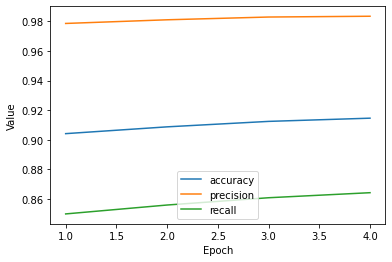

In [14]:
# parameters
learning_rate = 0.003
epochs = 5
batch_size=32
classification_threshold = 0.8
label_name = 'label'

metrics = [
    tf.keras.metrics.BinaryAccuracy(
        name='accuracy', 
        threshold=classification_threshold
    ),
    tf.keras.metrics.Precision(
        name='precision',
        thresholds=classification_threshold
    ),
    tf.keras.metrics.Recall(
        name="recall",
        thresholds=classification_threshold
    ),
]

# Rename the column name to match the expect input. 
train.rename(columns={"imports":'imports_input'}, inplace=True)
valid.rename(columns={"imports":'imports_input'}, inplace=True)
test.rename(columns={"imports":'imports_input'}, inplace=True)

model = Build_Model(learning_rate, hub_layer, metrics)

epochs, hist = Train_Model(model, train[['imports_input','label']], epochs, label_name, valid[['imports_input', 'label']], batch_size)

metrics_to_plot = ['accuracy', 'precision', 'recall']

Plot_Curve(epochs, hist, metrics_to_plot)

In [15]:
features = {name:np.array(value) for name, value in train[['imports_input','label']].items()}
label = np.array(features.pop(label_name))
imports_pred = model.predict(features)

# Sections

In [79]:
import ast
sections_column = [ast.literal_eval(i) for i in df['sections']]
section_dict ={} #Dict of of all unique section names with key=section name and value=count of section in the data
for entry in sections_column:
    for section in entry:
        try:
            section_name = ''.join(e for e in section[0] if e.isalnum()).lower()
        except:
            section_name = ''.join(e for e in section[0].decode('utf8', 'ignore') if e.isalnum()).lower()
        try:
            duplicate = 0
            section_dict[section_name] += 1
        except KeyError:
            section_dict[section_name] = 1
summmary_df = pd.DataFrame(data=[section_dict.keys(),section_dict.values()]).T
summmary_df.columns = ['name','count']
summmary_df.head(20)

,name,count
0,text,79603
1,rdata,47485
2,data,68845
3,sxdata,2685
4,rsrc,84529
5,reloc,55883
6,ndata,1601
7,rdatap,524
8,brdata,526
9,tc,471


In [80]:
TOP_PERCENTILE = 95 #About 40 sections comprise 95% of the data, can increase the granularity but this explodes the feature space and takes WAY too long to finish
summmary_df = summmary_df.sort_values(by='count',ascending=False).reset_index(drop=True)
summmary_df['%_of_total'] = summmary_df['count']/sum(summmary_df['count'])*100
summmary_df['cumulative_%'] = summmary_df['%_of_total'].cumsum()

top_sections = summmary_df[summmary_df['cumulative_%']<TOP_PERCENTILE]['name'].values.tolist()
col_names = ['r_size','v_size','code','executable','writable']
final_df = pd.DataFrame()
df_list = []

for row,section_sample in enumerate(sections_column):
    merged_df = pd.DataFrame()
    completed_sections = []
    for i in section_sample:
        try:
            i[0] = ''.join(e for e in i[0] if e.isalnum()).lower()
        except:
            i[0] = ''.join(e for e in i[0].decode('utf8', 'ignore') if e.isalnum()).lower()
        if (i[0] in completed_sections) or (i[0] not in top_sections):
            continue
        completed_sections.append(i[0])
        temp_df = pd.DataFrame([i[1:]],columns=col_names).add_prefix(f'{i[0]}_')
        merged_df = pd.concat([merged_df,temp_df],axis=1)
    df_list.append(merged_df)
#     final_df = pd.concat([final_df,merged_df],ignore_index=True).fillna(0)
    print(f'Completed {row/len(sections_column)*100:0.2f}%',end='\r')

In [81]:
#Some samples have no sections in the top percentile hence they have empyty dataframes,this column will be removed later
for row,i in enumerate(df_list):
    if i.empty:
        df_list[row] = pd.DataFrame({"EMPTY_PLACEHOLDER": [0]})

sections_df = pd.concat(df_list,ignore_index=True)
sections_df = sections_df.fillna(0)
sections_df = sections_df.drop(columns='EMPTY_PLACEHOLDER')
sections_df.drop(columns=['_code', '_executable', '_writable', '_r_size','_v_size'], inplace=True)
sections_df.head()

,text_r_size,text_v_size,text_code,text_executable,text_writable,rdata_r_size,rdata_v_size,rdata_code,rdata_executable,rdata_writable,data_r_size,data_v_size,data_code,data_executable,data_writable,sxdata_r_size,sxdata_v_size,sxdata_code,sxdata_executable,sxdata_writable,rsrc_r_size,rsrc_v_size,rsrc_code,rsrc_executable,rsrc_writable,reloc_r_size,reloc_v_size,reloc_code,reloc_executable,reloc_writable,ndata_r_size,ndata_v_size,ndata_code,ndata_executable,ndata_writable,rdatap_r_size,rdatap_v_size,rdatap_code,rdatap_executable,rdatap_writable,brdata_r_size,brdata_v_size,brdata_code,brdata_executable,brdata_writable,upx0_r_size,upx0_v_size,upx0_code,upx0_executable,upx0_writable,upx1_r_size,upx1_v_size,upx1_code,upx1_executable,upx1_writable,pdata_r_size,pdata_v_size,pdata_code,pdata_executable,pdata_writable,tls_r_size,tls_v_size,tls_code,tls_executable,tls_writable,idata_r_size,idata_v_size,idata_code,idata_executable,idata_writable,crt_r_size,crt_v_size,crt_code,crt_executable,crt_writable,upx2_r_size,upx2_v_size,upx2_code,upx2_executable,upx2_writable,gfids_r_size,gfids_v_size,gfids_code,gfids_executable,gfids_writable,code_r_size,code_v_size,code_code,code_executable,code_writable,bss_r_size,bss_v_size,bss_code,bss_executable,bss_writable,didat_r_size,didat_v_size,didat_code,didat_executable,didat_writable,aspack_r_size,aspack_v_size,aspack_code,aspack_executable,aspack_writable,xdata_r_size,xdata_v_size,xdata_code,xdata_executable,xdata_writable,edata_r_size,edata_v_size,edata_code,edata_executable,edata_writable,itext_r_size,itext_v_size,itext_code,itext_executable,itext_writable,adata_r_size,adata_v_size,adata_code,adata_executable,adata_writable,didata_r_size,didata_v_size,didata_code,didata_executable,didata_writable,rmnet_r_size,rmnet_v_size,rmnet_code,rmnet_executable,rmnet_writable,tsustub_r_size,tsustub_v_size,tsustub_code,tsustub_executable,tsustub_writable,tsuarch_r_size,tsuarch_v_size,tsuarch_code,tsuarch_executable,tsuarch_writable,orpc_r_size,orpc_v_size,orpc_code,orpc_executable,orpc_writable
0,29696.0,29442.0,1.0,1.0,0.0,38400.0,38006.0,0.0,0.0,0.0,1024.0,36828.0,0.0,0.0,1.0,512.0,8.0,0.0,0.0,1.0,13312.0,12936.0,0.0,0.0,0.0,1536.0,1274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,196608.0,194161.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4096.0,1960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,262144.0,261943.0,1.0,1.0,0.0,89600.0,89294.0,0.0,0.0,0.0,7680.0,11404.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,749568.0,749176.0,0.0,0.0,0.0,15872.0,15488.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23552.0,23364.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [82]:
sect = sections_df.copy()
sect = pd.concat([df['label'], sect], axis=1)
sect.head()

,label,text_r_size,text_v_size,text_code,text_executable,text_writable,rdata_r_size,rdata_v_size,rdata_code,rdata_executable,rdata_writable,data_r_size,data_v_size,data_code,data_executable,data_writable,sxdata_r_size,sxdata_v_size,sxdata_code,sxdata_executable,sxdata_writable,rsrc_r_size,rsrc_v_size,rsrc_code,rsrc_executable,rsrc_writable,reloc_r_size,reloc_v_size,reloc_code,reloc_executable,reloc_writable,ndata_r_size,ndata_v_size,ndata_code,ndata_executable,ndata_writable,rdatap_r_size,rdatap_v_size,rdatap_code,rdatap_executable,rdatap_writable,brdata_r_size,brdata_v_size,brdata_code,brdata_executable,brdata_writable,upx0_r_size,upx0_v_size,upx0_code,upx0_executable,upx0_writable,upx1_r_size,upx1_v_size,upx1_code,upx1_executable,upx1_writable,pdata_r_size,pdata_v_size,pdata_code,pdata_executable,pdata_writable,tls_r_size,tls_v_size,tls_code,tls_executable,tls_writable,idata_r_size,idata_v_size,idata_code,idata_executable,idata_writable,crt_r_size,crt_v_size,crt_code,crt_executable,crt_writable,upx2_r_size,upx2_v_size,upx2_code,upx2_executable,upx2_writable,gfids_r_size,gfids_v_size,gfids_code,gfids_executable,gfids_writable,code_r_size,code_v_size,code_code,code_executable,code_writable,bss_r_size,bss_v_size,bss_code,bss_executable,bss_writable,didat_r_size,didat_v_size,didat_code,didat_executable,didat_writable,aspack_r_size,aspack_v_size,aspack_code,aspack_executable,aspack_writable,xdata_r_size,xdata_v_size,xdata_code,xdata_executable,xdata_writable,edata_r_size,edata_v_size,edata_code,edata_executable,edata_writable,itext_r_size,itext_v_size,itext_code,itext_executable,itext_writable,adata_r_size,adata_v_size,adata_code,adata_executable,adata_writable,didata_r_size,didata_v_size,didata_code,didata_executable,didata_writable,rmnet_r_size,rmnet_v_size,rmnet_code,rmnet_executable,rmnet_writable,tsustub_r_size,tsustub_v_size,tsustub_code,tsustub_executable,tsustub_writable,tsuarch_r_size,tsuarch_v_size,tsuarch_code,tsuarch_executable,tsuarch_writable,orpc_r_size,orpc_v_size,orpc_code,orpc_executable,orpc_writable
0,1,29696.0,29442.0,1.0,1.0,0.0,38400.0,38006.0,0.0,0.0,0.0,1024.0,36828.0,0.0,0.0,1.0,512.0,8.0,0.0,0.0,1.0,13312.0,12936.0,0.0,0.0,0.0,1536.0,1274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,196608.0,194161.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4096.0,1960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,262144.0,261943.0,1.0,1.0,0.0,89600.0,89294.0,0.0,0.0,0.0,7680.0,11404.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,749568.0,749176.0,0.0,0.0,0.0,15872.0,15488.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,23552.0,23364.0,1.0,1.0,0.0,0.0,0.

In [83]:
train, val, test = np.split(sect.sample(frac=1), [int(0.8*len(sect)), int(0.9*len(sect))])

print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

74318 training examples
9290 validation examples
9290 test examples


In [84]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('label')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

batch_size = 5
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of targets:', label_batch )

C:\Users\blake\AppData\Local\Temp/ipykernel_21168/1785328546.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Every feature: ['label', 'text_r_size', 'text_v_size', 'text_code', 'text_executable', 'text_writable', 'rdata_r_size', 'rdata_v_size', 'rdata_code', 'rdata_executable', 'rdata_writable', 'data_r_size', 'data_v_size', 'data_code', 'data_executable', 'data_writable', 'sxdata_r_size', 'sxdata_v_size', 'sxdata_code', 'sxdata_executable', 'sxdata_writable', 'rsrc_r_size', 'rsrc_v_size', 'rsrc_code', 'rsrc_executable', 'rsrc_writable', 'reloc_r_size', 'reloc_v_size', 'reloc_code', 'reloc_executable', 'reloc_writable', 'ndata_r_size', 'ndata_v_size', 'ndata_code', 'ndata_executable', 'ndata_writable', 'rdatap_r_size', 'rdatap_v_size', 'rdatap_code', 'rdatap_executable', 'rdatap_writable', 'brdata_r_size', 'brdata_v_size', 'brdata_code', 'brdata_executable', 'brdata_writable', 'upx0_r_size', 'upx0_v_size', 'upx0_code', 'upx0_executable', 'upx0_writable', 'upx1_r_size', 'upx1_v_size', 'upx1_code', 'upx1_executable', 'upx1_writable', 'pdata_r_size', 'pdata_v_size', 'pdata_code', 'pdata_executab

In [85]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [86]:
photo_count_col = sect['text_r_size']
layer = get_normalization_layer('text_r_size', train_ds)
layer(photo_count_col)

<tf.Tensor: shape=(1, 92898), dtype=float32, numpy=
array([[-0.0164463 , -0.01331942, -0.01209168, ..., -0.01495959,
        -0.0165614 , -0.01631202]], dtype=float32)>

In [87]:
test_age_col = sect['text_code']
test_age_layer = get_category_encoding_layer(name='text_code',
                                             dataset=train_ds,
                                             dtype='float',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 1.], dtype=float32)>

In [88]:
columns = sect.columns
all_inputs = []
encoded_features = []

for col in columns:
    if col.endswith('size'):
        numeric_col = tf.keras.Input(shape=(1,), name=col)
        normalization_layer = get_normalization_layer(col, train_ds)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)

    if col.endswith('code') or col.endswith('writable') or col.endswith('executable'):
        categorical_col = tf.keras.Input(
            shape=(1,), 
            name=col, 
            dtype='float'
        )
        encoding_layer = get_category_encoding_layer(
            name=col,
            dataset=train_ds,
            dtype='float',
            max_tokens=2
        )
        encoded_categorical_col = encoding_layer(categorical_col)
        all_inputs.append(categorical_col)
        encoded_features.append(encoded_categorical_col)

In [89]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(
    256,
    activation='relu',
    kernel_regularizer='l2',
    name='Hidden_1'
)(all_features)
#x = layers.Dropout(0.1, name='Dropout')(x)
x = layers.Dense(
    128,
    activation='relu',
    kernel_regularizer='l2',
    name='Hidden_2'
)(x)
x = layers.Dense(
    64,
    activation='relu',
    kernel_regularizer='l2',
    name='Hidden_3'
)(x)
x = layers.Dense(
    32,
    activation='relu',
    kernel_regularizer='l2',
    name='Hidden_4'
)(x)
output = layers.Dense(
    1,
    activation='sigmoid',
    name='Sigmoid'
)(x)
#output = layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [90]:
classification_threshold = 0.6

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name='accuracy', 
            threshold=classification_threshold
        ),
        tf.keras.metrics.Precision(
            name='precision',
            thresholds=classification_threshold
        ),
        tf.keras.metrics.Recall(
            name="recall",
            thresholds=classification_threshold
        ),
    ]
)

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [91]:
batch_size = 64
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

history = model.fit(
    train_ds, 
    epochs=5, 
    validation_data=val_ds
)

epochs = history.epoch

hist = pd.DataFrame(history.history)

C:\Users\blake\AppData\Local\Temp/ipykernel_21168/1785328546.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Epoch 1/5


C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1162/1162 [==============================] - 120s 100ms/step - loss: 0.8607 - accuracy: 0.7582 - precision: 0.8645 - recall: 0.6813 - val_loss: 0.5257 - val_accuracy: 0.7665 - val_precision: 0.9597 - val_recall: 0.6106
Epoch 2/5
1162/1162 [==============================] - 121s 104ms/step - loss: 0.5041 - accuracy: 0.7806 - precision: 0.8787 - recall: 0.7124 - val_loss: 0.4762 - val_accuracy: 0.7858 - val_precision: 0.9494 - val_recall: 0.6540
Epoch 3/5
1162/1162 [==============================] - 122s 105ms/step - loss: 0.4725 - accuracy: 0.7894 - precision: 0.8841 - recall: 0.7245 - val_loss: 0.4539 - val_accuracy: 0.7879 - val_precision: 0.9502 - val_recall: 0.6575
Epoch 4/5
1162/1162 [==============================] - 121s 104ms/step - loss: 0.4558 - accuracy: 0.7968 - precision: 0.8898 - recall: 0.7333 - val_loss: 0.4407 - val_accuracy: 0.7906 - val_precision: 0.9503 - val_recall: 0.6625
Epoch 5/5
1162/1162 [==============================] - 125s 107ms/step - loss: 0.4450 - accura

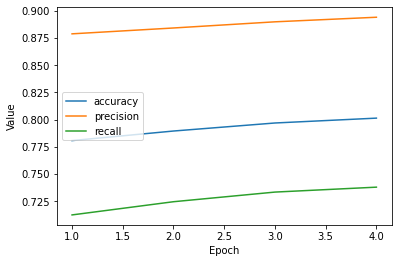

In [92]:
metrics_to_plot = ['accuracy', 'precision', 'recall']

Plot_Curve(epochs, hist, metrics_to_plot)

In [93]:
train_ds = df_to_dataset(train, shuffle=False, batch_size=batch_size)
sections_pred = model.predict(train_ds)

C:\Users\blake\AppData\Local\Temp/ipykernel_21168/1785328546.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\blake\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


# Final Model

In [179]:
# Covert the data to dataframes. 
final_df = pd.concat(
    [
        df[['label', 'file_entropy']],
        pd.DataFrame(imports_pred, columns=['imports']),
        pd.DataFrame(type_pred, columns=['type']),
        pd.DataFrame(sections_pred, columns=['sections'])
    ], axis=1
)
final_df.rename(columns={'file_entropy':'entropy'}, inplace=True)
final_df = final_df.iloc[:50000]
final_df.sample(10)
df.loc[29638]

index                                                                43521
label                                                                    1
file_type                PE32 executable (GUI) Intel 80386 Mono/.Net as...
file_size                                                         0.003819
file_entropy                                                      0.790723
imports                                                        _CorExeMain
exports                                                                 []
size_of_image                                                     0.000717
size_of_code                                                      0.000112
size_of_stack_reserve                                             0.001143
size_of_stack_commit                                              0.000004
size_of_heap_reserve                                              0.000538
size_of_heap_commit                                               0.000003
number_of_sections       

In [180]:
columns = ['entropy', 'imports', 'type', 'sections']
feature_columns = []

for col in columns:
    feature_columns.append(feature_column.numeric_column(col))

feature_layer = layers.DenseFeatures(feature_columns)

In [181]:
model = tf.keras.Sequential()
model = tf.keras.Sequential()
model.add(feature_layer)
model.add(layers.Dense(
    64,
    activation='relu',
    kernel_regularizer='l2',
    name='Hidden_1'
))
model.add(layers.Dense(
    128,
    activation='relu',
    kernel_regularizer='l2',
    name='Hidden_2'
))

model.add(layers.Dense(
    64,
    activation='relu',
    kernel_regularizer='l2',
    name='Hidden_3'
))

model.add(layers.Dropout(0.1, name='Dropout'))


model.add(layers.Dense(
    1,
    activation='sigmoid',
    name='Sigmoid'
))


classification_threshold = 0.52
learning_rate = 0.003

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name='accuracy', 
            threshold=classification_threshold
        ),
        tf.keras.metrics.Precision(
            name='precision',
            thresholds=classification_threshold
        ),
        tf.keras.metrics.Recall(
            name="recall",
            thresholds=classification_threshold
        ),
    ]
)

In [182]:
batch_size = 16

train, test = train_test_split(final_df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.2)

train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(valid, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

history = model.fit(
   train_ds, 
   epochs=50, 
   validation_data=val_ds
)

epochs = history.epoch

hist = pd.DataFrame(history.history)

#pred = model.predict(train_ds)

Epoch 1/50


C:\Users\blake\AppData\Local\Temp/ipykernel_21168/1785328546.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


1999/2000 [============================>.] - ETA: 0s - loss: 0.7024 - accuracy: 0.5457 - precision: 0.5672 - recall: 0.8313WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'label': <tf.Tensor 'IteratorGetNext:2' shape=(None, 1) dtype=int64>, 'entropy': <tf.Tensor 'IteratorGetNext:0' shape=(None, 1) dtype=float64>, 'imports': <tf.Tensor 'IteratorGetNext:1' shape=(None, 1) dtype=float32>, 'type': <tf.Tensor 'IteratorGetNext:4' shape=(None, 1) dtype=float32>, 'sections': <tf.Tensor 'IteratorGetNext:3' shape=(None, 1) dtype=float32>}. Consider rewriting this model with the Functional API.


2000/2000 [==============================] - 19s 9ms/step - loss: 0.7024 - accuracy: 0.5458 - precision: 0.5673 - recall: 0.8314 - val_loss: 0.6820 - val_accuracy: 0.5749 - val_precision: 0.5749 - val_recall: 1.0000
Epoch 2/50
2000/2000 [==============================] - 18s 9ms/step - loss: 0.6847 - accuracy: 0.5465 - precision: 0.5652 - recall: 0.8608 - val_loss: 0.6846 - val_accuracy: 0.4251 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
2000/2000 [==============================] - 18s 9ms/step - loss: 0.6847 - accuracy: 0.5480 - precision: 0.5659 - recall: 0.8634 - val_loss: 0.6820 - val_accuracy: 0.5749 - val_precision: 0.5749 - val_recall: 1.0000
Epoch 4/50
2000/2000 [==============================] - 18s 9ms/step - loss: 0.6847 - accuracy: 0.5617 - precision: 0.5663 - recall: 0.9617 - val_loss: 0.6821 - val_accuracy: 0.5749 - val_precision: 0.5749 - val_recall: 1.0000
Epoch 5/50
2000/2000 [==============================] - 18s 9ms/step - loss: 0.6846 - accuracy:

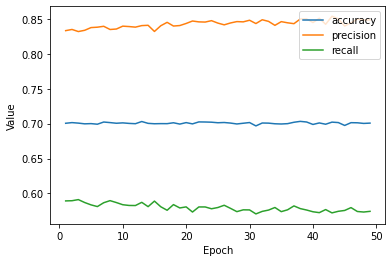

In [155]:
metrics_to_plot = ['accuracy', 'precision', 'recall']

Plot_Curve(epochs, hist, metrics_to_plot)

In [162]:
pred[29638]

array([0.37847328], dtype=float32)